In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_gedmd_torch_gpu import KoopmanNNTorch as KoopmanNNTorch_g
from solver_gedmd_torch_gpu import  KoopmanSolverTorch as KoopmanSolverTorch_g
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
# device= 'cpu'
device= 'cuda'

2.3.1 True
11.8
NVIDIA GeForce RTX 3070 Ti


In [2]:
## Define the potential function V(x, y) and plot the potential landscape
def potential(x, y):
    return (
        3 * np.exp(-x**2 - (y - 1/3)**2)
        - 3 * np.exp(-x**2 - (y - 5/3)**2)
        - 5 * np.exp(-(x - 1)**2 - y**2)
        - 5 * np.exp(-(x + 1)**2 - y**2)
        + 0.2 * x**4
        + 0.2 * (y - 1/3)**4
    )

# Define the gradient of the potential function
def gradient(x, y):
    dVdx = (
        -6 * x * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * x * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * (x - 1) * np.exp(-(x - 1)**2 - y**2)
        + 10 * (x + 1) * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * x**3
    )
    dVdy = (
        -6 * (y - 1/3) * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * (y - 5/3) * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * y * np.exp(-(x - 1)**2 - y**2)
        + 10 * y * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * (y - 1/3)**3
    )
    return dVdx, dVdy

## Generate m^2 trajectories in the landscape
# Set the parameters for the SDE
#h = 1e-3  # Integration step size
h = 1e-4  # Integration step size
#h = 1e-5  # Integration step size
n_steps = 100  # Number of integration steps between each evaluation
n_eval = 10  # Number of evaluations
lag_time = h * n_steps  # Lag time

# Set the number of points to select in each dimension
m = 12

# Set the diffusion coefficient
sigma = 1.09
print ('Lag time: ', lag_time)

Lag time:  0.01


In [3]:
# Generate linspace for x and y coordinates
x_values = np.linspace(-2, 2, m)
y_values = np.linspace(-1, 2, m)

# Create a meshgrid from these linspace arrays
xx, yy = np.meshgrid(x_values, y_values)

# Flatten the meshgrid matrices to get the coordinate pairs
x0_values = xx.flatten()
y0_values = yy.flatten()

# Initialize the data_matrix
data_matrix = np.zeros((m**2, n_eval+1, 2))

# Generate trajectories for each selected point
for i in tqdm (range(m**2)):
    x = x0_values[i]
    y = y0_values[i]
    
    for j in range(n_eval+1):
        data_matrix[i, j, 0] = x
        data_matrix[i, j, 1] = y
        
        for k in range(n_steps):
            dVdx, dVdy = gradient(x, y)
            x += -dVdx * h + sigma * np.sqrt(h) * np.random.normal()
            y += -dVdy * h + sigma * np.sqrt(h) * np.random.normal()

# Create a grid of points
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-1, 2, 100)
X, Y = np.meshgrid(x_plot, y_plot)

100%|██████████| 144/144 [00:01<00:00, 72.75it/s]


In [4]:
# ## Save the data to local folder
# # Create a folder to store the data (if it doesn't exist)
# folder_path = "data"
# os.makedirs(folder_path, exist_ok=True)

# # Save the data_matrix to a file
# file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
# np.save(file_path, data_matrix)

In [5]:
# ## load the data from local folder
# import os
# # Load the data_matrix from the file
# folder_path = "data"
# file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
# data_matrix = np.load(file_path)
# data_matrix.shape

In [6]:
!nvidia-smi

Tue Dec 10 10:30:58 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   47C    P8             18W /  290W |    4247MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

Shape of data_X: (144, 10, 2)
Shape of data_Y: (144, 10, 2)
Shape of X: (1440, 2)
Shape of Y: (1440, 2)
(1007, 2)


In [8]:


checkpoint_file= 'well2d_example_ckpt004.torch'

basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=7).to(device)  # basis number would be 20


solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn001.torch', 
                            a_b_file= 'a_b_example_3ple_well.jbl', 
                        generator_batch_size= 2, fnn_batch_size= 32, delta_t= lag_time)

solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=16,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
#kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver.get_Psi_X()
Psi_Y = solver.get_Psi_Y()
Koopman_matrix_K = solver.K

outputs = {
    'efuns': efuns,
    'evalues': evalues,
#    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    }



Epoch: 1 	Training Loss: 1.385690 val loss: 1.180623
saving, val loss enhanced: 1.1806226125320054 10000
Epoch: 2 	Training Loss: 1.364655 val loss: 1.184054
Epoch: 3 	Training Loss: 1.349393 val loss: 1.135647
saving, val loss enhanced: 1.135647026906942 1.1806226125320054
Epoch: 4 	Training Loss: 1.334611 val loss: 1.142656
Epoch: 5 	Training Loss: 1.313566 val loss: 1.136603
Epoch: 6 	Training Loss: 1.290462 val loss: 1.126157
saving, val loss enhanced: 1.1261571664906664 1.135647026906942
Epoch: 7 	Training Loss: 1.274911 val loss: 1.107949
saving, val loss enhanced: 1.1079486084581742 1.1261571664906664
Epoch: 8 	Training Loss: 1.262602 val loss: 1.087496
saving, val loss enhanced: 1.0874956299416276 1.1079486084581742
Epoch: 9 	Training Loss: 1.249075 val loss: 1.080131
saving, val loss enhanced: 1.0801310477060777 1.0874956299416276
Epoch: 10 	Training Loss: 1.232752 val loss: 1.059666
saving, val loss enhanced: 1.0596660380247018 1.0801310477060777
Epoch: 11 	Training Loss: 1.2

Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4349.29iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
saving FNN a and b to:  a_b_example_3ple_well.jbl
Outer Epoch 1/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4011.50iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003250 val loss: 0.003058
saving, val loss enhanced: 0.0030580123656906255 1000000000000000.0
Epoch: 2 	Training Loss: 0.003249 val loss: 0.003058
saving, val loss enhanced: 0.0030575649647142035 0.0030580123656906255
Epoch: 3 	Training Loss: 0.003248 val loss: 0.003057
saving, val loss enhanced: 0.003057117828515523 0.0030575649647142035
Epoch: 4 	Training Loss: 0.003248 val loss: 0.003057
saving, val loss enhanced: 0.003056671011002829 0.003057117828515523
Epoch 1 time: 4.52 seconds
Outer Epoch 2/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4414.93iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003246 val loss: 0.003056
saving, val loss enhanced: 0.0030558496397938115 0.003056671011002829
Epoch: 2 	Training Loss: 0.003246 val loss: 0.003055
saving, val loss enhanced: 0.0030554042872903632 0.0030558496397938115
Epoch: 3 	Training Loss: 0.003245 val loss: 0.003055
saving, val loss enhanced: 0.0030549593690149843 0.0030554042872903632
Epoch: 4 	Training Loss: 0.003245 val loss: 0.003055
saving, val loss enhanced: 0.0030545148752800406 0.0030549593690149843
Epoch 2 time: 4.18 seconds
Outer Epoch 3/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4479.78iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003243 val loss: 0.003054
saving, val loss enhanced: 0.0030537269050183477 0.0030545148752800406
Epoch: 2 	Training Loss: 0.003243 val loss: 0.003053
saving, val loss enhanced: 0.00305328398869269 0.0030537269050183477
Epoch: 3 	Training Loss: 0.003242 val loss: 0.003053
saving, val loss enhanced: 0.003052841555528816 0.00305328398869269
Epoch: 4 	Training Loss: 0.003241 val loss: 0.003052
saving, val loss enhanced: 0.003052399579321197 0.003052841555528816
Epoch 3 time: 4.16 seconds
Outer Epoch 4/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4269.31iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003240 val loss: 0.003052
saving, val loss enhanced: 0.0030516265898891514 0.003052399579321197
Epoch: 2 	Training Loss: 0.003240 val loss: 0.003051
saving, val loss enhanced: 0.0030511862275320665 0.0030516265898891514
Epoch: 3 	Training Loss: 0.003239 val loss: 0.003051
saving, val loss enhanced: 0.003050746361619924 0.0030511862275320665
Epoch: 4 	Training Loss: 0.003238 val loss: 0.003050
saving, val loss enhanced: 0.003050306958966643 0.003050746361619924
Epoch 4 time: 4.27 seconds
Outer Epoch 5/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4223.39iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003237 val loss: 0.003050
saving, val loss enhanced: 0.0030495488559538386 0.003050306958966643
Epoch: 2 	Training Loss: 0.003237 val loss: 0.003049
saving, val loss enhanced: 0.003049111062742917 0.0030495488559538386
Epoch: 3 	Training Loss: 0.003236 val loss: 0.003049
saving, val loss enhanced: 0.0030486737658843013 0.003049111062742917
Epoch: 4 	Training Loss: 0.003235 val loss: 0.003048
saving, val loss enhanced: 0.003048236929563022 0.0030486737658843013
Epoch 5 time: 4.30 seconds
Outer Epoch 6/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4231.28iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003234 val loss: 0.003047
saving, val loss enhanced: 0.0030474932918818534 0.003048236929563022
Epoch: 2 	Training Loss: 0.003233 val loss: 0.003047
saving, val loss enhanced: 0.003047058046936885 0.0030474932918818534
Epoch: 3 	Training Loss: 0.003233 val loss: 0.003047
saving, val loss enhanced: 0.0030466232940621783 0.003047058046936885
Epoch: 4 	Training Loss: 0.003232 val loss: 0.003046
saving, val loss enhanced: 0.0030461889965005097 0.0030466232940621783
Epoch 6 time: 4.28 seconds
Outer Epoch 7/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4310.87iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003231 val loss: 0.003045
saving, val loss enhanced: 0.003045459827195841 0.0030461889965005097
Epoch: 2 	Training Loss: 0.003230 val loss: 0.003045
saving, val loss enhanced: 0.0030450270987371322 0.003045459827195841
Epoch: 3 	Training Loss: 0.003230 val loss: 0.003045
saving, val loss enhanced: 0.003044594856829632 0.0030450270987371322
Epoch: 4 	Training Loss: 0.003229 val loss: 0.003044
saving, val loss enhanced: 0.003044163064443179 0.003044594856829632
Epoch 7 time: 4.26 seconds
Outer Epoch 8/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4152.28iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003228 val loss: 0.003043
saving, val loss enhanced: 0.0030434480260966117 0.003044163064443179
Epoch: 2 	Training Loss: 0.003227 val loss: 0.003043
saving, val loss enhanced: 0.0030430177795762736 0.0030434480260966117
Epoch: 3 	Training Loss: 0.003227 val loss: 0.003043
saving, val loss enhanced: 0.003042588013756934 0.0030430177795762736
Epoch: 4 	Training Loss: 0.003226 val loss: 0.003042
saving, val loss enhanced: 0.003042158691629385 0.003042588013756934
Epoch 8 time: 4.36 seconds
Outer Epoch 9/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4370.92iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003225 val loss: 0.003041
saving, val loss enhanced: 0.0030414570276370016 0.003042158691629385
Epoch: 2 	Training Loss: 0.003224 val loss: 0.003041
saving, val loss enhanced: 0.0030410292282572198 0.0030414570276370016
Epoch: 3 	Training Loss: 0.003224 val loss: 0.003041
saving, val loss enhanced: 0.0030406019036786614 0.0030410292282572198
Epoch: 4 	Training Loss: 0.003223 val loss: 0.003040
saving, val loss enhanced: 0.0030401750170596766 0.0030406019036786614
Epoch 9 time: 4.21 seconds
Outer Epoch 10/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4469.36iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003222 val loss: 0.003039
saving, val loss enhanced: 0.0030394872844070535 0.0030401750170596766
Epoch: 2 	Training Loss: 0.003222 val loss: 0.003039
saving, val loss enhanced: 0.003039061897391723 0.0030394872844070535
Epoch: 3 	Training Loss: 0.003221 val loss: 0.003039
saving, val loss enhanced: 0.003038636979254645 0.003039061897391723
Epoch: 4 	Training Loss: 0.003220 val loss: 0.003038
saving, val loss enhanced: 0.00303821249342942 0.003038636979254645
Epoch 10 time: 4.14 seconds
Outer Epoch 11/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4278.69iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003219 val loss: 0.003038
saving, val loss enhanced: 0.003037537737295328 0.00303821249342942
Epoch: 2 	Training Loss: 0.003219 val loss: 0.003037
saving, val loss enhanced: 0.0030371147285619088 0.003037537737295328
Epoch: 3 	Training Loss: 0.003218 val loss: 0.003037
saving, val loss enhanced: 0.0030366921828699008 0.0030371147285619088
Epoch: 4 	Training Loss: 0.003217 val loss: 0.003036
saving, val loss enhanced: 0.0030362700639748174 0.0030366921828699008
Epoch 11 time: 4.25 seconds
Outer Epoch 12/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4534.05iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003216 val loss: 0.003036
saving, val loss enhanced: 0.003035608450617306 0.0030362700639748174
Epoch: 2 	Training Loss: 0.003216 val loss: 0.003035
saving, val loss enhanced: 0.003035187786630119 0.003035608450617306
Epoch: 3 	Training Loss: 0.003215 val loss: 0.003035
saving, val loss enhanced: 0.0030347675799044637 0.003035187786630119
Epoch: 4 	Training Loss: 0.003215 val loss: 0.003034
saving, val loss enhanced: 0.0030343477945614958 0.0030347675799044637
Epoch 12 time: 4.12 seconds
Outer Epoch 13/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4374.70iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003213 val loss: 0.003034
saving, val loss enhanced: 0.003033698957680387 0.0030343477945614958
Epoch: 2 	Training Loss: 0.003213 val loss: 0.003033
saving, val loss enhanced: 0.003033280605445785 0.003033698957680387
Epoch: 3 	Training Loss: 0.003212 val loss: 0.003033
saving, val loss enhanced: 0.00303286270477261 0.003033280605445785
Epoch: 4 	Training Loss: 0.003212 val loss: 0.003032
saving, val loss enhanced: 0.003032445220173945 0.00303286270477261
Epoch 13 time: 4.19 seconds
Outer Epoch 14/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4363.31iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003211 val loss: 0.003032
saving, val loss enhanced: 0.0030318092378229986 0.003032445220173945
Epoch: 2 	Training Loss: 0.003210 val loss: 0.003031
saving, val loss enhanced: 0.0030313931649592987 0.0030318092378229986
Epoch: 3 	Training Loss: 0.003209 val loss: 0.003031
saving, val loss enhanced: 0.003030977538031628 0.0030313931649592987
Epoch: 4 	Training Loss: 0.003209 val loss: 0.003031
saving, val loss enhanced: 0.0030305623219668153 0.003030977538031628
Epoch 14 time: 4.16 seconds
Outer Epoch 15/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4083.19iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003208 val loss: 0.003030
saving, val loss enhanced: 0.0030299387091908083 0.0030305623219668153
Epoch: 2 	Training Loss: 0.003207 val loss: 0.003030
saving, val loss enhanced: 0.0030295248839100693 0.0030299387091908083
Epoch: 3 	Training Loss: 0.003207 val loss: 0.003029
saving, val loss enhanced: 0.0030291114990393785 0.0030295248839100693
Epoch: 4 	Training Loss: 0.003206 val loss: 0.003029
saving, val loss enhanced: 0.003028698519927466 0.0030291114990393785
Epoch 15 time: 4.31 seconds
Outer Epoch 16/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4481.39iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003205 val loss: 0.003028
saving, val loss enhanced: 0.0030280870637606904 0.003028698519927466
Epoch: 2 	Training Loss: 0.003204 val loss: 0.003028
saving, val loss enhanced: 0.003027675455013434 0.0030280870637606904
Epoch: 3 	Training Loss: 0.003204 val loss: 0.003027
saving, val loss enhanced: 0.0030272642812507024 0.003027675455013434
Epoch: 4 	Training Loss: 0.003203 val loss: 0.003027
saving, val loss enhanced: 0.003026853508247242 0.0030272642812507024
Epoch 16 time: 4.22 seconds


In [9]:
print (solver.L_Psi.shape, solver.dPsi_X.shape, solver.data_x_train[:-1, :].shape, solver.data_y_train.shape, solver.Psi_X.shape)

torch.Size([10, 10]) torch.Size([1006, 10]) (1006, 2) (1007, 2) torch.Size([1007, 10])


(10,)
[0.99993947 0.99733233 0.97661871 0.94419799 0.90249029 0.84128748
 0.34412344 0.08480324 0.03383151 0.0011078 ]


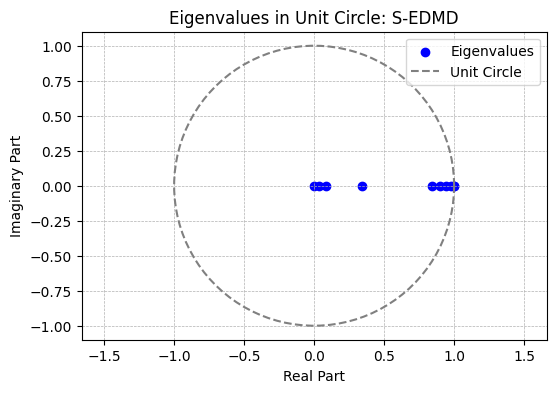

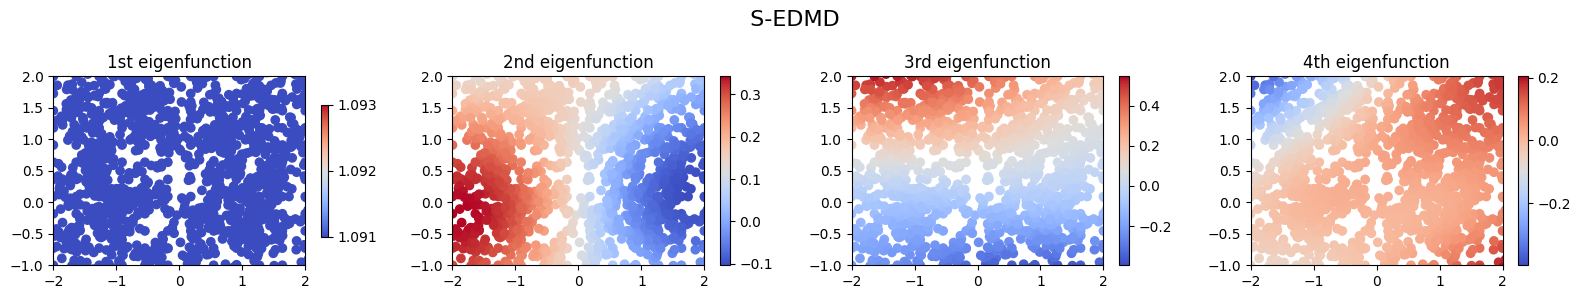

In [10]:
# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data

# Assuming evalues is a numpy array of complex numbers
print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: S-EDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])
fig.suptitle(' S-EDMD ', fontsize=16)
plt.tight_layout()
plt.show()


In [11]:
checkpoint_file_g= 'well2d_example_ckpt004_g.torch'

basis_function_g = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=7).to(device)  # basis number would be 20


solver_g = KoopmanSolverTorch_g(dic=basis_function_g, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file_g, fnn_checkpoint_file= 'example_fnn001.torch', 
                            a_b_file= 'a_b_example_3ple_well.jbl', 
                        generator_batch_size= 2, fnn_batch_size= 32)

solver_g.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=16,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_gedmd
evalues = solver_g.eigenvalues.T
efuns = solver_g.eigenfunctions(X)
#kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver_g.get_Psi_X()
Psi_Y = solver_g.get_Psi_Y()


outputs = {
    'efuns': efuns,
    'evalues': evalues,
#    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
#    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    }



Precomputed SDE coefficients loaded from: a_b_example_3ple_well.jbl
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5127.21iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Outer Epoch 1/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4957.03iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5194.24iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5025.15iteration/s]


Epoch: 1 	Training Loss: 22.946384 val loss: 34.330708
saving, val loss enhanced: 34.330708142468666 1000000000000000.0
Epoch: 2 	Training Loss: 22.927722 val loss: 34.309978
saving, val loss enhanced: 34.30997771104684 34.330708142468666
Epoch: 3 	Training Loss: 22.909247 val loss: 34.288965
saving, val loss enhanced: 34.288964739551574 34.30997771104684
Epoch: 4 	Training Loss: 22.890795 val loss: 34.267850
saving, val loss enhanced: 34.26784982426715 34.288964739551574
Epoch 1 time: 9.03 seconds
Outer Epoch 2/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5064.60iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5246.46iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5237.50iteration/s]


Epoch: 1 	Training Loss: 22.837272 val loss: 34.208308
saving, val loss enhanced: 34.20830829804581 34.26784982426715
Epoch: 2 	Training Loss: 22.818908 val loss: 34.187184
saving, val loss enhanced: 34.18718391972667 34.20830829804581
Epoch: 3 	Training Loss: 22.800561 val loss: 34.166056
saving, val loss enhanced: 34.16605597999674 34.18718391972667
Epoch: 4 	Training Loss: 22.782231 val loss: 34.144931
saving, val loss enhanced: 34.14493146215519 34.16605597999674
Epoch 2 time: 8.93 seconds
Outer Epoch 3/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5082.74iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5104.08iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5024.69iteration/s]


Epoch: 1 	Training Loss: 22.728586 val loss: 34.084935
saving, val loss enhanced: 34.084935138903944 34.14493146215519
Epoch: 2 	Training Loss: 22.710347 val loss: 34.063884
saving, val loss enhanced: 34.063883579356435 34.084935138903944
Epoch: 3 	Training Loss: 22.692130 val loss: 34.042845
saving, val loss enhanced: 34.042845439643784 34.063883579356435
Epoch: 4 	Training Loss: 22.673930 val loss: 34.021821
saving, val loss enhanced: 34.02182063427486 34.042845439643784
Epoch 3 time: 9.02 seconds
Outer Epoch 4/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5097.81iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5090.61iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5298.46iteration/s]


Epoch: 1 	Training Loss: 22.620644 val loss: 33.962192
saving, val loss enhanced: 33.96219232436354 34.02182063427486
Epoch: 2 	Training Loss: 22.602539 val loss: 33.941251
saving, val loss enhanced: 33.9412506478056 33.96219232436354
Epoch: 3 	Training Loss: 22.584457 val loss: 33.920325
saving, val loss enhanced: 33.92032470606461 33.9412506478056
Epoch: 4 	Training Loss: 22.566393 val loss: 33.899413
saving, val loss enhanced: 33.899413234341154 33.92032470606461
Epoch 4 time: 9.01 seconds
Outer Epoch 5/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5323.28iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5172.70iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5282.31iteration/s]


Epoch: 1 	Training Loss: 22.513493 val loss: 33.840200
saving, val loss enhanced: 33.84019963027388 33.899413234341154
Epoch: 2 	Training Loss: 22.495525 val loss: 33.819372
saving, val loss enhanced: 33.81937200282147 33.84019963027388
Epoch: 3 	Training Loss: 22.477579 val loss: 33.798560
saving, val loss enhanced: 33.79856014930979 33.81937200282147
Epoch: 4 	Training Loss: 22.459652 val loss: 33.777763
saving, val loss enhanced: 33.77776253986042 33.79856014930979
Epoch 5 time: 8.90 seconds
Outer Epoch 6/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5144.23iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5161.43iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5308.02iteration/s]


Epoch: 1 	Training Loss: 22.407146 val loss: 33.718979
saving, val loss enhanced: 33.7189789708365 33.77776253986042
Epoch: 2 	Training Loss: 22.389313 val loss: 33.698264
saving, val loss enhanced: 33.6982643205531 33.7189789708365
Epoch: 3 	Training Loss: 22.371504 val loss: 33.677565
saving, val loss enhanced: 33.677565142238564 33.6982643205531
Epoch: 4 	Training Loss: 22.353713 val loss: 33.656880
saving, val loss enhanced: 33.65687983086026 33.677565142238564
Epoch 6 time: 8.96 seconds
Outer Epoch 7/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5161.26iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5169.32iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5313.89iteration/s]


Epoch: 1 	Training Loss: 22.301601 val loss: 33.598530
saving, val loss enhanced: 33.598530374622115 33.65687983086026
Epoch: 2 	Training Loss: 22.283904 val loss: 33.577927
saving, val loss enhanced: 33.577926926696975 33.598530374622115
Epoch: 3 	Training Loss: 22.266229 val loss: 33.557339
saving, val loss enhanced: 33.557338638739346 33.577926926696975
Epoch: 4 	Training Loss: 22.248573 val loss: 33.536764
saving, val loss enhanced: 33.536763878052696 33.557338638739346
Epoch 7 time: 8.88 seconds
Outer Epoch 8/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4880.62iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5195.69iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4976.42iteration/s]


Epoch: 1 	Training Loss: 22.196854 val loss: 33.478848
saving, val loss enhanced: 33.47884777956863 33.536763878052696
Epoch: 2 	Training Loss: 22.179290 val loss: 33.458354
saving, val loss enhanced: 33.45835380894398 33.47884777956863
Epoch: 3 	Training Loss: 22.161749 val loss: 33.437875
saving, val loss enhanced: 33.43787471874204 33.45835380894398
Epoch: 4 	Training Loss: 22.144227 val loss: 33.417409
saving, val loss enhanced: 33.41740886509165 33.43787471874204
Epoch 8 time: 9.08 seconds
Outer Epoch 9/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5078.85iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5094.12iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5301.56iteration/s]


Epoch: 1 	Training Loss: 22.092897 val loss: 33.359923
saving, val loss enhanced: 33.359923094903166 33.41740886509165
Epoch: 2 	Training Loss: 22.075466 val loss: 33.339537
saving, val loss enhanced: 33.339537004406026 33.359923094903166
Epoch: 3 	Training Loss: 22.058057 val loss: 33.319166
saving, val loss enhanced: 33.31916554321204 33.339537004406026
Epoch: 4 	Training Loss: 22.040667 val loss: 33.298807
saving, val loss enhanced: 33.2988070647262 33.31916554321204
Epoch 9 time: 8.99 seconds
Outer Epoch 10/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4991.58iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4774.86iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4978.44iteration/s]


Epoch: 1 	Training Loss: 21.989722 val loss: 33.241747
saving, val loss enhanced: 33.241747442582344 33.2988070647262
Epoch: 2 	Training Loss: 21.972422 val loss: 33.221468
saving, val loss enhanced: 33.221467739732816 33.241747442582344
Epoch: 3 	Training Loss: 21.955144 val loss: 33.201202
saving, val loss enhanced: 33.2012024357232 33.221467739732816
Epoch: 4 	Training Loss: 21.937884 val loss: 33.180950
saving, val loss enhanced: 33.18094988674433 33.2012024357232
Epoch 10 time: 9.15 seconds
Outer Epoch 11/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5100.25iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5188.37iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4936.44iteration/s]


Epoch: 1 	Training Loss: 21.887320 val loss: 33.124312
saving, val loss enhanced: 33.12431162340598 33.18094988674433
Epoch: 2 	Training Loss: 21.870150 val loss: 33.104137
saving, val loss enhanced: 33.10413689385717 33.12431162340598
Epoch: 3 	Training Loss: 21.853001 val loss: 33.083976
saving, val loss enhanced: 33.08397634770461 33.10413689385717
Epoch: 4 	Training Loss: 21.835870 val loss: 33.063828
saving, val loss enhanced: 33.06382834787535 33.08397634770461
Epoch 11 time: 8.95 seconds
Outer Epoch 12/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5204.57iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5081.70iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5072.14iteration/s]


Epoch: 1 	Training Loss: 21.785683 val loss: 33.007606
saving, val loss enhanced: 33.00760632497168 33.06382834787535
Epoch: 2 	Training Loss: 21.768640 val loss: 32.987535
saving, val loss enhanced: 32.98753521412521 33.00760632497168
Epoch: 3 	Training Loss: 21.751620 val loss: 32.967478
saving, val loss enhanced: 32.9674780826046 32.98753521412521
Epoch: 4 	Training Loss: 21.734616 val loss: 32.947433
saving, val loss enhanced: 32.94743330300039 32.9674780826046
Epoch 12 time: 8.91 seconds
Outer Epoch 13/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4931.76iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5168.98iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5271.15iteration/s]


Epoch: 1 	Training Loss: 21.684800 val loss: 32.891622
saving, val loss enhanced: 32.89162222790863 32.94743330300039
Epoch: 2 	Training Loss: 21.667884 val loss: 32.871653
saving, val loss enhanced: 32.87165342903277 32.89162222790863
Epoch: 3 	Training Loss: 21.650990 val loss: 32.851698
saving, val loss enhanced: 32.851698414431326 32.87165342903277
Epoch: 4 	Training Loss: 21.634113 val loss: 32.831756
saving, val loss enhanced: 32.831755568555316 32.851698414431326
Epoch 13 time: 8.95 seconds
Outer Epoch 14/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5123.19iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5208.39iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4724.47iteration/s]


Epoch: 1 	Training Loss: 21.584664 val loss: 32.776350
saving, val loss enhanced: 32.776350069421 32.831755568555316
Epoch: 2 	Training Loss: 21.567873 val loss: 32.756482
saving, val loss enhanced: 32.75648231588584 32.776350069421
Epoch: 3 	Training Loss: 21.551104 val loss: 32.736628
saving, val loss enhanced: 32.736628159031966 32.75648231588584
Epoch: 4 	Training Loss: 21.534352 val loss: 32.716786
saving, val loss enhanced: 32.716785996828115 32.736628159031966
Epoch 14 time: 9.02 seconds
Outer Epoch 15/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5257.14iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5250.58iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5288.99iteration/s]


Epoch: 1 	Training Loss: 21.485264 val loss: 32.661781
saving, val loss enhanced: 32.661780681695426 32.716785996828115
Epoch: 2 	Training Loss: 21.468598 val loss: 32.642013
saving, val loss enhanced: 32.64201274173404 32.661780681695426
Epoch: 3 	Training Loss: 21.451952 val loss: 32.622258
saving, val loss enhanced: 32.62225821725049 32.64201274173404
Epoch: 4 	Training Loss: 21.435323 val loss: 32.602516
saving, val loss enhanced: 32.60251552098212 32.62225821725049
Epoch 15 time: 8.95 seconds
Outer Epoch 16/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5077.43iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5240.96iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5280.59iteration/s]


Epoch: 1 	Training Loss: 21.386593 val loss: 32.547905
saving, val loss enhanced: 32.54790501160844 32.60251552098212
Epoch: 2 	Training Loss: 21.370049 val loss: 32.528236
saving, val loss enhanced: 32.52823568465764 32.54790501160844
Epoch: 3 	Training Loss: 21.353525 val loss: 32.508580
saving, val loss enhanced: 32.50857959761623 32.52823568465764
Epoch: 4 	Training Loss: 21.337018 val loss: 32.488935
saving, val loss enhanced: 32.48893517893019 32.50857959761623
Epoch 16 time: 8.90 seconds
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4861.55iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0


(10,)
[ 2.46826336e+00+0.j          1.00687584e+00+0.j
  1.00000000e+00+0.j          5.19024743e-01+0.j
  3.25521475e-01-0.2563726j   3.25521475e-01+0.2563726j
 -1.81407897e-02-0.05327697j -1.81407897e-02+0.05327697j
 -6.34894996e-04-0.00112338j -6.34894996e-04+0.00112338j]


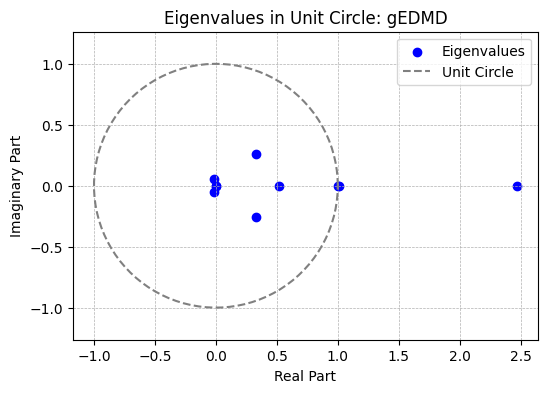

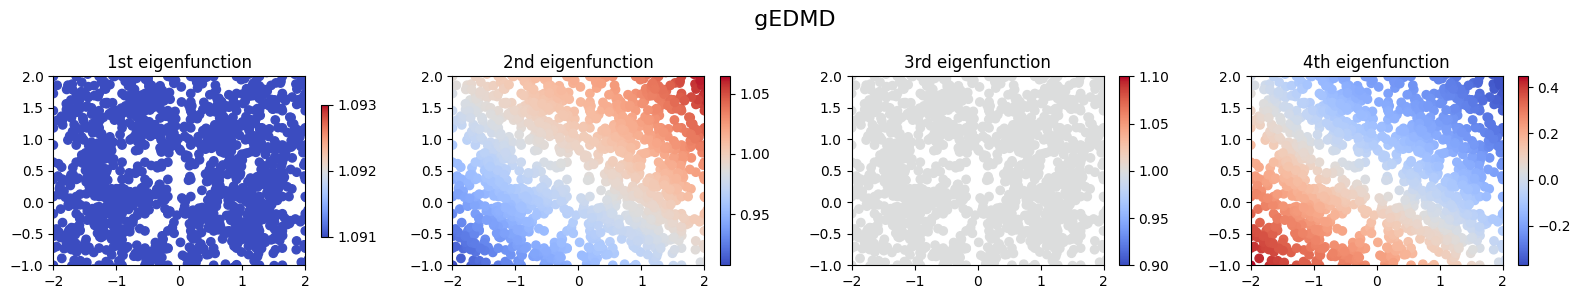

In [12]:
#computing eigenvalues of K from generator eigenvalues using exponetnt
#eigenfunctions are the same for the operator and the generator
evalues= np.exp(evalues)

# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data
# Assuming evalues is a numpy array of complex numbers

print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: gEDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])
fig.suptitle(' gEDMD ', fontsize=16)
plt.tight_layout()
plt.show()
